# NDBI




Normalized Difference Built-up Index (NDBI) adalah metode dari beberapa metode banyak digunakan untukmemproses dan analisis citra penginderaan jauh. NDBI hanya berfokus pada respons spektral kawasan terbangun dibandingkan dengan tutupan lahan lain. Metode ini menggunakan reflektansi inframerah gelombang pendek (SWIR), yang menunjukkan pantulan dari bangunan dan umumnya memiliki nilai lebih tinggi dibandingkan reflektansi inframerah dekat(NIR). Rumus untuk menghitung NDBI adalah sebagai berikut:

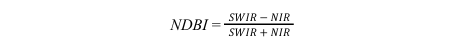      


Dimana SWIR adalah nilai piksel dari band short-wave infrared dan NIR adalah nilai piksel dari band near infrared band. [1]

# Import Library & autentikasi

In [25]:
#Import Library dan autentikasi GEE
import ee
ee.Authenticate()
ee.Initialize(project='ee-analafeanalber')

# Read Raster

In [26]:
#Membaca Raster dari assets GEE yang difilter berdasarkan Shapefile KabupatenKota di Provinsi Lampung
shapefile = ee.FeatureCollection('projects/ee-analafeanalber/assets/SHPKoka')
image_collection = ee.ImageCollection('COPERNICUS/S2') \
  .filterDate('2023-01-01', '2023-12-31') \
  .filterBounds(shapefile) \
  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
image = image_collection.median().select(['B4', 'B3', 'B2']) # Red, Green, Blue

# NDBI

In [27]:
#Proses Kalkulasi Jumlah Bangunan dengan NDBI
image_collection = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(shapefile) \
    .filterDate('2023-01-01', '2023-12-31') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))

image = image_collection.median()

# NDBI: (SWIR - NIR) / (SWIR + NIR)
ndbi = image.normalizedDifference(['B11', 'B8']).rename('NDBI')

# Mengatur Threshold NDBI untuk membuat binary mask(urban vs non-urban)
urban_mask = ndbi.gt(0)

# Apply the mask ke area urban
urban_image = urban_mask.updateMask(urban_mask)


# Output NDBI

In [28]:
import pandas as pd

# Kalkulasi jumlah bangunanan
connected_components = urban_image.connectedComponents(ee.Kernel.plus(1), 128)
building_count = connected_components.select('labels').connectedPixelCount(maxSize=128)

# Reduce batas SHP
building_count_per_village = building_count.reduceRegions(
    collection=shapefile,
    reducer=ee.Reducer.count(),
    scale=10
)

result = building_count_per_village.getInfo()

# List untuk menyimpan data
village_names = []
building_counts = []

# Loop hasil ke LIST
for feature in result['features']:
    village_name = feature['properties']['WADMKK']  # Adjust 'NAMOBJ' according to your SHP's field name
    count = feature['properties']['count']
    village_names.append(village_name)
    building_counts.append(count)

# Membuat dataframe Hasil
df = pd.DataFrame({
    'kabupatenkota': village_names,
    'jumlah bangunan': building_counts})
df


,kabupatenkota,jumlah bangunan
0,Bandar Lampung,84764
1,Metro,54362
2,Lampung Barat,2142387
3,Lampung Selatan,2281679
4,Lampung Tengah,4767085
5,Lampung Timur,3177249
6,Lampung Utara,2348771
7,Mesuji,28973
8,Pesawaran,918293
9,Pesisir Barat,594861


# Visualisasi

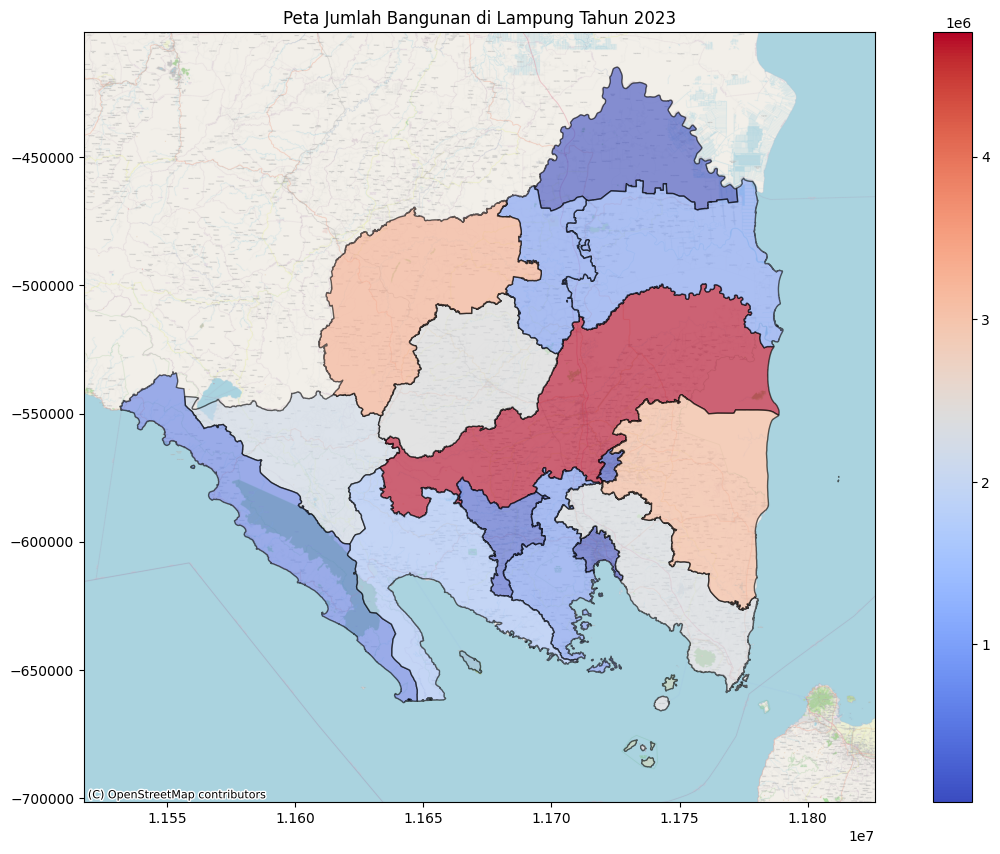

In [29]:
#!pip install contextily
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

shapefile_path = '/content/SHPKoka.shp'
gdf = gpd.read_file(shapefile_path)
gdf = gdf.merge(df, left_on='WADMKK', right_on='kabupatenkota')
gdf = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf.plot(column='jumlah bangunan', ax=ax, legend=True, cmap='coolwarm', edgecolor='black', alpha=0.6)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12)
plt.title('Peta Jumlah Bangunan di Lampung Tahun 2023')
plt.show()

# Analisis

Bisa terlihat dari perhitungan dengan Metode NDBI, bahwa jumlah bangunan yang terbanyak berada di Kabupaten Lampung Tengah pada area bewarna merah dan Kota Metro merupakan wilayah yang memiliki jumlah bangunan sedikit di Provinsi Lampung yang berwarna biru tua. Hal ini dipengaruhi luas wilayah Kota Metro kecil dibandingkan Kabupaten Lampung Tengah yang luas. Serta juga bisa dipengaruhi oleh faktor lain membuat wilayah tersebut memiliki jumlah bangunan sangat berbeda yaitu bisa dari jumlah penduduk bahkan kepadatan penduduk di wilayah tersebut.

# Export to Excel

In [30]:
df.to_excel('Jumlah Bangunan Kabupaten Kota di Provinsi Lampung-2023.xlsx', index=False)

# Referensi

Shofy, Y. F., & Wibowo, A. (2023). The Impact of the Trans-Java Toll Road Development on Spatial Planning in the Northern Region of Java Island: A Study Utilizing NDBI and Google Earth Images. Indonesian Journal of Earth Sciences, 3(1), A611. https://doi.org/10.52562/injoes.2023.611